In [2]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 778kB 9.2MB/s 
     |████████████████████████████████| 3.0MB 87kB/s 
     |████████████████████████████████| 890kB 41.5MB/s 
     |████████████████████████████████| 1.1MB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4ef321c4d462fef5da99ce0e86de76d589c6ba2745c32f19f971a88e95aa1b29
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import tensorflow as tf

In [4]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [5]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:



df = pd.read_csv(data_path + 'new_train.csv',sep="\t")
df['encoded_categories'] = df['category']=="normal"
df['encoded_categories']=df['encoded_categories'].astype('int')
df1 = pd.read_csv(data_path + 'new_test.csv',sep="\t")
df1['encoded_categories'] = df1['category']=="normal"
df1['encoded_categories']=df1['encoded_categories'].astype('int')
print(df.groupby("encoded_categories").size())
print(df1.groupby("encoded_categories").size())

encoded_categories
0    58630
1    67343
dtype: int64
encoded_categories
0    12833
1     9710
dtype: int64


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentences = df.text.values
max_len = 80

In [8]:
print(sentences[0])
print(tokenizer.tokenize(sentences[0]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
#print(max([len(sen) for sen in input_ids]))

0 tcp ftp_data SF 491 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 150 25 0.17 0.03 0.17 0 0 0 0.05 0
['0', 'tc', '##p', 'ft', '##p', '_', 'data', 'sf', '49', '##1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '0', '0', '0', '0', '1', '0', '0', '150', '25', '0', '.', '17', '0', '.', '03', '0', '.', '17', '0', '0', '0', '0', '.', '05', '0']
[1014, 22975, 2361, 3027, 2361, 1035, 2951, 16420, 4749, 2487, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1016, 1016, 1014, 1014, 1014, 1014, 1015, 1014, 1014, 5018, 2423, 1014, 1012, 2459, 1014, 1012, 6021, 1014, 1012, 2459, 1014, 1014, 1014, 1014, 1012, 5709, 1014]


In [ ]:
#EKKKKKKKKKKKKKKKKKK

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Original:  0 tcp ftp_data SF 491 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 150 25 0.17 0.03 0.17 0 0 0 0.05 0
Token IDs: [101, 1014, 22975, 2361, 3027, 2361, 1035, 2951, 16420, 4749, 2487, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1016, 1016, 1014, 1014, 1014, 1014, 1015, 1014, 1014, 5018, 2423, 1014, 1012, 2459, 1014, 1012, 6021, 1014, 1012, 2459, 1014, 1014, 1014, 1014, 1012, 5709, 1014, 102]


Max sentence length:  75


In [9]:
training = df
test = df1

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values
training_labels = training.encoded_categories.values

Training:  125973
Test:  22543


In [10]:
#training_labels = training.encoded_categories.values
print(test.groupby("category").size())

category
DoS       7458
Probe     2421
R2L       2754
U2R        200
normal    9710
dtype: int64


In [11]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                        truncation=True,
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Original:  0 tcp ftp_data SF 491 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 150 25 0.17 0.03 0.17 0 0 0 0.05 0
Token IDs: tensor([  101,  1014, 22975,  2361,  3027,  2361,  1035,  2951, 16420,  4749,
         2487,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,
         1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1016,  1016,
         1014,  1014,  1014,  1014,  1015,  1014,  1014,  5018,  2423,  1014,
         1012,  2459,  1014,  1012,  6021,  1014,  1012,  2459,  1014,  1014,
         1014,  1014,  1012,  5709,  1014,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [12]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)
model=""
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [14]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of  3,937.    Elapsed: 0:00:05.
Batch    20  of  3,937.    Elapsed: 0:00:09.
Batch    30  of  3,937.    Elapsed: 0:00:14.
Batch    40  of  3,937.    Elapsed: 0:00:19.
Batch    50  of  3,937.    Elapsed: 0:00:23.
Batch    60  of  3,937.    Elapsed: 0:00:28.
Batch    70  of  3,937.    Elapsed: 0:00:33.
Batch    80  of  3,937.    Elapsed: 0:00:38.
Batch    90  of  3,937.    Elapsed: 0:00:43.
Batch   100  of  3,937.    Elapsed: 0:00:48.
Batch   110  of  3,937.    Elapsed: 0:00:52.
Batch   120  of  3,937.    Elapsed: 0:00:57.
Batch   130  of  3,937.    Elapsed: 0:01:02.
Batch   140  of  3,937.    Elapsed: 0:01:06.
Batch   150  of  3,937.    Elapsed: 0:01:11.
Batch   160  of  3,937.    Elapsed: 0:01:15.
Batch   170  of  3,937.    Elapsed: 0:01:20.
Batch   180  of  3,937.    Elapsed: 0:01:24.
Batch   190  of  3,937.    Elapsed: 0:01:29.
Batch   200  of  3,937.    Elapsed: 0:01:33.
Batch   210  of  3,937.    Elapsed: 0:01:38.
Batch   220  of  3,937.  

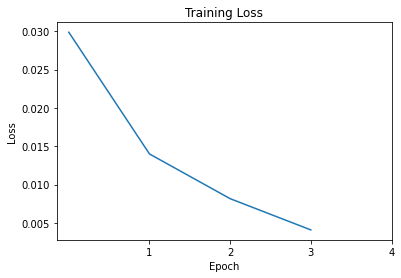

In [15]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [16]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',  
                        truncation=True, 
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [17]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [18]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'0',
                          '1':'1',
                          '2':'2',
                          '3':'3',
                          '4':'4'})

print(report)

F-Score:  0.7902427131066003
Recall:  0.8072661697125949
Precision:  0.8093144574383921
                      0            1  accuracy     macro avg  weighted avg
precision      0.928156     0.690473  0.790267      0.809314      0.825778
recall         0.684563     0.929969  0.790267      0.807266      0.790267
f1-score       0.787963     0.792522  0.790267      0.790243      0.789927
support    12833.000000  9710.000000  0.790267  22543.000000  22543.000000


In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
cm=confusion_matrix(test_labels, prediction_scores)

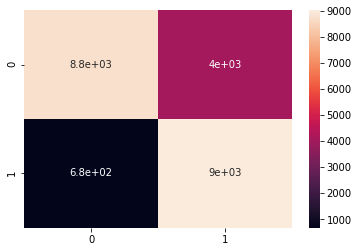

In [21]:
cm=confusion_matrix(test_labels, prediction_scores)
sns.heatmap(cm, annot=True)

In [22]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [23]:
print(report.to_string())

                      0            1  accuracy     macro avg  weighted avg
precision      0.928156     0.690473  0.790267      0.809314      0.825778
recall         0.684563     0.929969  0.790267      0.807266      0.790267
f1-score       0.787963     0.792522  0.790267      0.790243      0.789927
support    12833.000000  9710.000000  0.790267  22543.000000  22543.000000


In [24]:
str(cm)

'[[8785 4048]\n [ 680 9030]]'

In [25]:
cm

array([[8785, 4048],
       [ 680, 9030]])

In [26]:
#training_labels = training.encoded_categories.values
print(test.groupby("category").size())

category
DoS       7458
Probe     2421
R2L       2754
U2R        200
normal    9710
dtype: int64


In [27]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [28]:
!ls -l --block-size=K ./model_save/

total 427992K
-rw-r--r-- 1 root root      1K Aug  3 00:00 config.json
-rw-r--r-- 1 root root 427752K Aug  3 00:00 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug  3 00:00 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug  3 00:00 tokenizer_config.json
-rw-r--r-- 1 root root    227K Aug  3 00:00 vocab.txt


In [29]:
!cp -r ./model_save/ "/content/drive/My Drive/resource/"

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)